In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import pickle

# Progress bar
from tqdm import tqdm

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as ltb

# Custom classes
import sys
sys.path.insert(0,'..')
from meta_learning import MetaLearner, Model, evaluator
from utils import load_dataset

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Macros

In [2]:
META_LABEL_METRIC = "kappa"
DATASET = "covertype"

BASE_MODEL = RandomForestClassifier
# BASE_MODEL_HYPERPARAMS = {"probability": True}  # SVC
BASE_MODEL_HYPERPARAMS = {"max_depth": 6}  # RandomForest and DecisionTree
# BASE_MODEL_HYPERPARAMS = {}  # Logistic Regression

META_MODEL = ltb.LGBMRegressor
META_MODEL_HYPERPARAMS = {"num_leaves": 21, "max_depth": 5}

FILE_NAME = f"metamodel: {META_MODEL.__name__} - basemodel: {BASE_MODEL.__name__} - metric: {META_LABEL_METRIC} - dataset: {DATASET}"
FILE_NAME

'metamodel: LGBMRegressor - basemodel: RandomForestClassifier - metric: kappa - dataset: covertype'

In [3]:
# Macros
CLASS_COL = "class"
BASE_MODEL_TYPE = "multiclass"  # or binary_classification/regression

OFFLINE_PHASE_SIZE = 50000
BASE_TRAIN_SIZE = 30000
R_STATE = 123

ETA = 100  # Window size used to extract meta features
STEP = 30  # Step for next meta learning iteration
TARGET_DELAY = 500

## Read data

In [4]:
df = load_dataset(DATASET)
print(df.shape)
df.head()

(581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,0.875366,...,0,0,0,0,0,0,0,0,0,5
1,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,0.867838,...,0,0,0,0,0,0,0,0,0,5
2,0.472736,0.386111,0.136364,0.191840,0.307494,0.446817,0.921260,0.937008,0.531496,0.853339,...,0,0,0,0,0,0,0,0,0,2
3,0.463232,0.430556,0.272727,0.173228,0.375969,0.434172,0.937008,0.937008,0.480315,0.865886,...,0,0,0,0,0,0,0,0,0,2
4,0.368184,0.125000,0.030303,0.109520,0.222222,0.054939,0.866142,0.921260,0.590551,0.860449,...,0,0,0,0,0,0,0,0,0,5


In [5]:
n = df.shape[0]
class_weight = df[CLASS_COL].value_counts().apply(lambda x: x/n).to_dict()
class_weight

{'2': 0.48759922342395684,
 '1': 0.36460520608868663,
 '3': 0.06153745533655071,
 '7': 0.03530047572167184,
 '6': 0.02989094889606411,
 '5': 0.016338733107061472,
 '4': 0.004727957426008413}

In [6]:
# offline
offline_df = df.iloc[:OFFLINE_PHASE_SIZE]
base_train_df = offline_df.iloc[:BASE_TRAIN_SIZE]
meta_train_df = offline_df.iloc[BASE_TRAIN_SIZE:]

# online
online_df = df.iloc[OFFLINE_PHASE_SIZE:]
online_features = online_df.drop(CLASS_COL, axis=1).reset_index(drop=True)
online_targets = online_df[CLASS_COL].reset_index(drop=True)

## Offline stage

In [7]:
base_model = Model(verbose=True, basis_model=BASE_MODEL, hyperparameters=BASE_MODEL_HYPERPARAMS)
meta_model = Model(verbose=True, basis_model=META_MODEL, hyperparameters=META_MODEL_HYPERPARAMS)
learner_params = {
    "base_model": base_model,
    "meta_model": meta_model,
    "base_model_class_column": CLASS_COL,
    "eta": ETA,
    "step": STEP,
    "meta_label_metric": META_LABEL_METRIC,
    "verbose": True,
    "target_delay": TARGET_DELAY,
    "base_model_type": BASE_MODEL_TYPE,
    }

learner = MetaLearner(**learner_params).fit(base_train_df, meta_train_df)

Training model with instances 0 to 664
Training model with instances 0 to 664


## Online Stage

In [8]:
# start - no target
with tqdm(total=TARGET_DELAY) as pbar:
    for i, row in online_features.iloc[:TARGET_DELAY].iterrows():
        learner.update(row)
        pbar.update(1)

100%|██████████| 500/500 [00:55<00:00,  9.05it/s]


In [9]:
# middle - both target and instances
df = online_features.iloc[TARGET_DELAY:-TARGET_DELAY]

with tqdm(total=df.shape[0]) as pbar:
    for i, row in df.iterrows():
        learner.update(row)
        learner.update_target(online_targets.iloc[i - TARGET_DELAY])
        pbar.update(1)

  0%|          | 898/530012 [01:43<13:06:08, 11.22it/s]

Training model with instances 30 to 694


  0%|          | 1799/530012 [03:27<13:35:49, 10.79it/s]

Training model with instances 60 to 724


  1%|          | 2699/530012 [05:11<12:09:46, 12.04it/s]

Training model with instances 90 to 754


  1%|          | 3598/530012 [06:55<11:59:37, 12.19it/s]

Training model with instances 120 to 784


  1%|          | 4498/530012 [08:37<12:41:59, 11.49it/s]

Training model with instances 150 to 814


  1%|          | 5398/530012 [10:21<9:14:59, 15.75it/s] 

Training model with instances 180 to 844


  1%|          | 6299/530012 [11:38<9:05:59, 15.99it/s] 

Training model with instances 210 to 874


  1%|▏         | 7198/530012 [12:55<9:22:06, 15.50it/s] 

Training model with instances 240 to 904


  2%|▏         | 8099/530012 [14:13<9:48:16, 14.79it/s] 

Training model with instances 270 to 934


  2%|▏         | 8999/530012 [15:32<9:30:21, 15.22it/s] 

Training model with instances 300 to 964


  2%|▏         | 9899/530012 [16:49<10:56:50, 13.20it/s]

Training model with instances 330 to 994


  2%|▏         | 10799/530012 [18:08<9:24:35, 15.33it/s] 

Training model with instances 360 to 1024


  2%|▏         | 11699/530012 [19:26<10:50:00, 13.29it/s]

Training model with instances 390 to 1054


  2%|▏         | 12599/530012 [20:46<9:29:52, 15.13it/s] 

Training model with instances 420 to 1084


  3%|▎         | 13498/530012 [22:15<10:04:08, 14.25it/s]

Training model with instances 450 to 1114


  3%|▎         | 14398/530012 [23:37<8:54:25, 16.08it/s] 

Training model with instances 480 to 1144


  3%|▎         | 15299/530012 [25:02<11:29:06, 12.45it/s]

Training model with instances 510 to 1174


  3%|▎         | 16198/530012 [26:33<9:30:33, 15.01it/s] 

Training model with instances 540 to 1204


  3%|▎         | 17098/530012 [27:55<9:50:27, 14.48it/s] 

Training model with instances 570 to 1234


  3%|▎         | 17998/530012 [29:17<9:18:20, 15.28it/s] 

Training model with instances 600 to 1264


  4%|▎         | 18898/530012 [30:40<9:44:48, 14.57it/s] 

Training model with instances 630 to 1294


  4%|▎         | 19799/530012 [32:03<9:56:44, 14.25it/s] 

Training model with instances 660 to 1324


  4%|▍         | 20698/530012 [33:27<10:40:34, 13.25it/s]

Training model with instances 690 to 1354


  4%|▍         | 21599/530012 [34:52<9:53:18, 14.28it/s] 

Training model with instances 720 to 1384


  4%|▍         | 22499/530012 [36:17<9:22:24, 15.04it/s] 

Training model with instances 750 to 1414


  4%|▍         | 23399/530012 [37:41<10:14:48, 13.73it/s]

Training model with instances 780 to 1444


  5%|▍         | 24298/530012 [39:08<9:42:49, 14.46it/s] 

Training model with instances 810 to 1474


  5%|▍         | 25198/530012 [40:33<9:58:15, 14.06it/s] 

Training model with instances 840 to 1504


  5%|▍         | 26098/530012 [42:00<10:28:47, 13.36it/s]

Training model with instances 870 to 1534


  5%|▌         | 26998/530012 [43:27<10:31:52, 13.27it/s]

Training model with instances 900 to 1564


  5%|▌         | 27898/530012 [44:56<10:19:08, 13.52it/s]

Training model with instances 930 to 1594


  5%|▌         | 28799/530012 [46:25<10:42:00, 13.01it/s]

Training model with instances 960 to 1624


  6%|▌         | 29698/530012 [48:10<13:04:48, 10.62it/s] 

Training model with instances 990 to 1654


  6%|▌         | 30599/530012 [50:34<12:58:34, 10.69it/s]

Training model with instances 1020 to 1684


  6%|▌         | 31498/530012 [52:27<12:21:12, 11.21it/s]

Training model with instances 1050 to 1714


  6%|▌         | 32398/530012 [54:20<12:26:05, 11.12it/s]

Training model with instances 1080 to 1744


  6%|▋         | 33298/530012 [56:16<12:43:44, 10.84it/s]

Training model with instances 1110 to 1774


  6%|▋         | 34199/530012 [58:06<12:38:23, 10.90it/s]

Training model with instances 1140 to 1804


  7%|▋         | 35099/530012 [59:57<11:54:48, 11.54it/s]

Training model with instances 1170 to 1834


  7%|▋         | 35998/530012 [1:01:46<12:12:51, 11.23it/s]

Training model with instances 1200 to 1864


  7%|▋         | 36898/530012 [1:03:35<12:43:58, 10.76it/s]

Training model with instances 1230 to 1894


  7%|▋         | 37799/530012 [1:05:24<12:51:36, 10.63it/s]

Training model with instances 1260 to 1924


  7%|▋         | 38698/530012 [1:07:14<12:27:09, 10.96it/s]

Training model with instances 1290 to 1954


  7%|▋         | 39599/530012 [1:09:04<15:47:46,  8.62it/s]

Training model with instances 1320 to 1984


  8%|▊         | 40498/530012 [1:11:14<10:01:01, 13.57it/s] 

Training model with instances 1350 to 2014


  8%|▊         | 41399/530012 [1:12:45<10:04:09, 13.48it/s]

Training model with instances 1380 to 2044


  8%|▊         | 42299/530012 [1:14:17<11:46:27, 11.51it/s]

Training model with instances 1410 to 2074


  8%|▊         | 43198/530012 [1:15:50<9:53:29, 13.67it/s] 

Training model with instances 1440 to 2104


  8%|▊         | 44099/530012 [1:17:22<10:37:48, 12.70it/s]

Training model with instances 1470 to 2134


  8%|▊         | 44999/530012 [1:18:54<10:28:45, 12.86it/s]

Training model with instances 1500 to 2164


  9%|▊         | 45900/530012 [1:20:28<17:04:18,  7.88it/s]

Training model with instances 1530 to 2194


  9%|▉         | 46799/530012 [1:22:01<11:21:46, 11.81it/s]

Training model with instances 1560 to 2224


  9%|▉         | 47699/530012 [1:23:41<13:16:08, 10.10it/s]

Training model with instances 1590 to 2254


  9%|▉         | 48600/530012 [1:25:22<17:16:13,  7.74it/s]

Training model with instances 1620 to 2284


  9%|▉         | 49498/530012 [1:27:01<12:01:31, 11.10it/s]

Training model with instances 1650 to 2314


 10%|▉         | 50399/530012 [1:28:37<9:54:57, 13.44it/s] 

Training model with instances 1680 to 2344


 10%|▉         | 51299/530012 [1:30:14<10:35:53, 12.55it/s]

Training model with instances 1710 to 2374


 10%|▉         | 52200/530012 [1:32:04<20:51:16,  6.36it/s] 

Training model with instances 1740 to 2404


 10%|█         | 53099/530012 [1:34:12<22:12:04,  5.97it/s]

Training model with instances 1770 to 2434


 10%|█         | 54000/530012 [1:35:54<18:56:38,  6.98it/s]

Training model with instances 1800 to 2464


 10%|█         | 54899/530012 [1:38:01<11:30:12, 11.47it/s] 

Training model with instances 1830 to 2494


 11%|█         | 55799/530012 [1:39:41<9:51:21, 13.37it/s] 

Training model with instances 1860 to 2524


 11%|█         | 56700/530012 [1:41:16<16:47:48,  7.83it/s]

Training model with instances 1890 to 2554


 11%|█         | 57599/530012 [1:43:04<9:07:54, 14.37it/s] 

Training model with instances 1920 to 2584


 11%|█         | 58499/530012 [1:44:28<8:48:03, 14.88it/s] 

Training model with instances 1950 to 2614


 11%|█         | 59399/530012 [1:45:52<8:54:16, 14.68it/s] 

Training model with instances 1980 to 2644


 11%|█▏        | 60299/530012 [1:47:17<8:56:32, 14.59it/s] 

Training model with instances 2010 to 2674


 12%|█▏        | 61199/530012 [1:48:40<9:00:05, 14.47it/s] 

Training model with instances 2040 to 2704


 12%|█▏        | 62099/530012 [1:50:03<9:05:07, 14.31it/s] 

Training model with instances 2070 to 2734


 12%|█▏        | 62999/530012 [1:51:38<9:55:59, 13.06it/s] 

Training model with instances 2100 to 2764


 12%|█▏        | 63899/530012 [1:53:15<13:00:09,  9.96it/s]

Training model with instances 2130 to 2794


 12%|█▏        | 64799/530012 [1:54:52<9:22:17, 13.79it/s] 

Training model with instances 2160 to 2824


 12%|█▏        | 65699/530012 [1:56:19<9:18:43, 13.85it/s] 

Training model with instances 2190 to 2854


 13%|█▎        | 66599/530012 [1:57:51<9:03:48, 14.20it/s] 

Training model with instances 2220 to 2884


 13%|█▎        | 67498/530012 [1:59:26<9:30:38, 13.51it/s] 

Training model with instances 2250 to 2914


 13%|█▎        | 68398/530012 [2:01:16<12:38:04, 10.15it/s]

Training model with instances 2280 to 2944


 13%|█▎        | 69299/530012 [2:02:55<9:26:03, 13.56it/s] 

Training model with instances 2310 to 2974


 13%|█▎        | 70199/530012 [2:04:36<9:17:57, 13.73it/s]  

Training model with instances 2340 to 3004


 13%|█▎        | 71099/530012 [2:06:11<9:22:29, 13.60it/s] 

Training model with instances 2370 to 3034


 14%|█▎        | 71998/530012 [2:07:51<9:19:33, 13.64it/s] 

Training model with instances 2400 to 3064


 14%|█▍        | 72898/530012 [2:09:25<9:14:44, 13.73it/s] 

Training model with instances 2430 to 3094


 14%|█▍        | 73799/530012 [2:10:58<10:09:19, 12.48it/s]

Training model with instances 2460 to 3124


 14%|█▍        | 74699/530012 [2:12:40<9:25:24, 13.42it/s] 

Training model with instances 2490 to 3154


 14%|█▍        | 75599/530012 [2:14:11<9:09:46, 13.78it/s] 

Training model with instances 2520 to 3184


 14%|█▍        | 76499/530012 [2:15:42<9:17:54, 13.55it/s] 

Training model with instances 2550 to 3214


 15%|█▍        | 77399/530012 [2:17:11<9:32:47, 13.17it/s] 

Training model with instances 2580 to 3244


 15%|█▍        | 78298/530012 [2:18:41<9:18:10, 13.49it/s] 

Training model with instances 2610 to 3274


 15%|█▍        | 79199/530012 [2:20:12<9:25:34, 13.28it/s] 

Training model with instances 2640 to 3304


 15%|█▌        | 80099/530012 [2:21:42<9:26:06, 13.25it/s] 

Training model with instances 2670 to 3334


 15%|█▌        | 80999/530012 [2:23:14<10:35:29, 11.78it/s]

Training model with instances 2700 to 3364


 15%|█▌        | 81899/530012 [2:24:52<11:01:21, 11.29it/s]

Training model with instances 2730 to 3394


 16%|█▌        | 82799/530012 [2:26:25<9:25:05, 13.19it/s] 

Training model with instances 2760 to 3424


 16%|█▌        | 83698/530012 [2:28:07<9:18:37, 13.32it/s] 

Training model with instances 2790 to 3454


 16%|█▌        | 84598/530012 [2:29:41<9:19:16, 13.27it/s] 

Training model with instances 2820 to 3484


 16%|█▌        | 85499/530012 [2:31:13<9:34:42, 12.89it/s] 

Training model with instances 2850 to 3514


 16%|█▋        | 86399/530012 [2:32:48<9:24:00, 13.11it/s] 

Training model with instances 2880 to 3544


 16%|█▋        | 87299/530012 [2:34:22<9:19:47, 13.18it/s] 

Training model with instances 2910 to 3574


 17%|█▋        | 88200/530012 [2:36:04<15:55:08,  7.71it/s]

Training model with instances 2940 to 3604


 17%|█▋        | 89100/530012 [2:37:40<15:44:58,  7.78it/s]

Training model with instances 2970 to 3634


 17%|█▋        | 89999/530012 [2:39:31<18:20:48,  6.66it/s]

Training model with instances 3000 to 3664


 17%|█▋        | 90899/530012 [2:41:05<9:36:14, 12.70it/s] 

Training model with instances 3030 to 3694


 17%|█▋        | 91799/530012 [2:42:39<9:32:01, 12.77it/s] 

Training model with instances 3060 to 3724


 17%|█▋        | 92699/530012 [2:44:25<9:28:39, 12.82it/s] 

Training model with instances 3090 to 3754


 18%|█▊        | 93599/530012 [2:46:21<12:24:05,  9.78it/s]

Training model with instances 3120 to 3784


 18%|█▊        | 94499/530012 [2:48:16<9:30:57, 12.71it/s] 

Training model with instances 3150 to 3814


 18%|█▊        | 95398/530012 [2:49:54<9:26:43, 12.78it/s] 

Training model with instances 3180 to 3844


 18%|█▊        | 96298/530012 [2:51:29<9:56:08, 12.13it/s] 

Training model with instances 3210 to 3874


 18%|█▊        | 97199/530012 [2:53:14<10:03:55, 11.94it/s]

Training model with instances 3240 to 3904


 19%|█▊        | 98098/530012 [2:54:55<9:39:59, 12.41it/s] 

Training model with instances 3270 to 3934


 19%|█▊        | 98999/530012 [2:56:35<9:27:57, 12.65it/s] 

Training model with instances 3300 to 3964


 19%|█▉        | 99899/530012 [2:58:20<15:44:07,  7.59it/s]

Training model with instances 3330 to 3994


 19%|█▉        | 100799/530012 [3:00:13<18:41:25,  6.38it/s]

Training model with instances 3360 to 4024


 19%|█▉        | 101699/530012 [3:02:06<9:34:39, 12.42it/s] 

Training model with instances 3390 to 4054


 19%|█▉        | 102598/530012 [3:03:46<10:10:39, 11.67it/s]

Training model with instances 3420 to 4084


 20%|█▉        | 103499/530012 [3:05:30<10:00:49, 11.83it/s]

Training model with instances 3450 to 4114


 20%|█▉        | 104399/530012 [3:07:11<9:34:48, 12.34it/s] 

Training model with instances 3480 to 4144


 20%|█▉        | 105299/530012 [3:09:09<11:25:57, 10.32it/s] 

Training model with instances 3510 to 4174


 20%|██        | 106199/530012 [3:11:01<9:51:23, 11.94it/s]  

Training model with instances 3540 to 4204


 20%|██        | 107099/530012 [3:12:55<9:37:13, 12.21it/s] 

Training model with instances 3570 to 4234


 20%|██        | 107999/530012 [3:14:40<9:45:01, 12.02it/s] 

Training model with instances 3600 to 4264


 21%|██        | 108899/530012 [3:16:21<9:30:53, 12.29it/s] 

Training model with instances 3630 to 4294


 21%|██        | 109799/530012 [3:18:03<9:26:22, 12.37it/s] 

Training model with instances 3660 to 4324


 21%|██        | 110699/530012 [3:19:44<9:41:33, 12.02it/s] 

Training model with instances 3690 to 4354


 21%|██        | 111598/530012 [3:21:26<9:51:47, 11.78it/s] 

Training model with instances 3720 to 4384


 21%|██        | 112498/530012 [3:23:23<10:12:55, 11.35it/s]

Training model with instances 3750 to 4414


 21%|██▏       | 113399/530012 [3:25:21<13:24:05,  8.64it/s]

Training model with instances 3780 to 4444


 22%|██▏       | 114298/530012 [3:27:15<12:08:17,  9.51it/s]

Training model with instances 3810 to 4474


 22%|██▏       | 115198/530012 [3:29:27<10:47:19, 10.68it/s]

Training model with instances 3840 to 4504


 22%|██▏       | 116099/530012 [3:31:16<10:05:26, 11.39it/s]

Training model with instances 3870 to 4534


 22%|██▏       | 116998/530012 [3:33:08<10:44:55, 10.67it/s]

Training model with instances 3900 to 4564


 22%|██▏       | 117899/530012 [3:35:17<12:26:47,  9.20it/s]

Training model with instances 3930 to 4594


 22%|██▏       | 118798/530012 [3:37:14<10:10:42, 11.22it/s]

Training model with instances 3960 to 4624


 23%|██▎       | 119699/530012 [3:39:14<10:16:03, 11.10it/s]

Training model with instances 3990 to 4654


 23%|██▎       | 120599/530012 [3:41:06<10:24:19, 10.93it/s]

Training model with instances 4020 to 4684


 23%|██▎       | 121499/530012 [3:42:58<11:00:41, 10.31it/s]

Training model with instances 4050 to 4714


 23%|██▎       | 122398/530012 [3:44:51<10:17:59, 10.99it/s]

Training model with instances 4080 to 4744


 23%|██▎       | 123298/530012 [3:46:46<10:27:20, 10.81it/s]

Training model with instances 4110 to 4774


 23%|██▎       | 124198/530012 [3:48:47<10:39:05, 10.58it/s]

Training model with instances 4140 to 4804


 24%|██▎       | 125098/530012 [3:51:03<11:23:52,  9.87it/s]

Training model with instances 4170 to 4834


 24%|██▍       | 125998/530012 [3:53:23<10:47:50, 10.39it/s]

Training model with instances 4200 to 4864


 24%|██▍       | 126899/530012 [3:55:30<10:35:11, 10.58it/s]

Training model with instances 4230 to 4894


 24%|██▍       | 127799/530012 [3:57:25<10:12:45, 10.94it/s]

Training model with instances 4260 to 4924


 24%|██▍       | 128698/530012 [3:59:22<10:19:40, 10.79it/s]

Training model with instances 4290 to 4954


 24%|██▍       | 129598/530012 [4:01:24<10:36:08, 10.49it/s]

Training model with instances 4320 to 4984


 25%|██▍       | 130498/530012 [4:03:33<11:08:12,  9.96it/s]

Training model with instances 4350 to 5014


 25%|██▍       | 130568/530012 [4:03:43<13:16:10,  8.36it/s]

In [ ]:
# end - only targets
with tqdm(total=TARGET_DELAY) as pbar:
    for target in online_targets.tail(TARGET_DELAY):
        learner.update_target(target)
        pbar.update(1)

100%|██████████| 500/500 [00:00<00:00, 1413.56it/s]


## Results

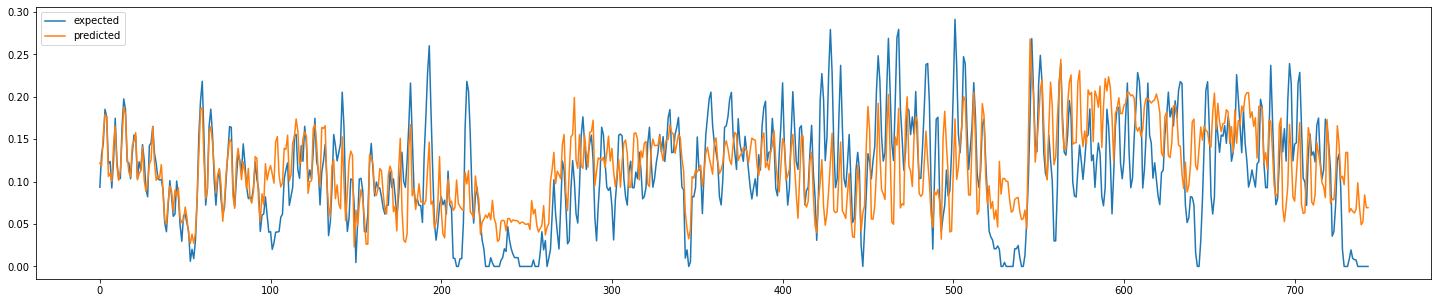

In [ ]:
mb = learner.metabase.metabase

y_true = mb[META_LABEL_METRIC]
y_pred = mb['predicted']
x = range(len(y_true))

fig = plt.figure(figsize=(25, 5))
plt.plot(x, y_true, label="expected")
plt.plot(x, y_pred, label="predicted")
plt.legend(loc="upper left")

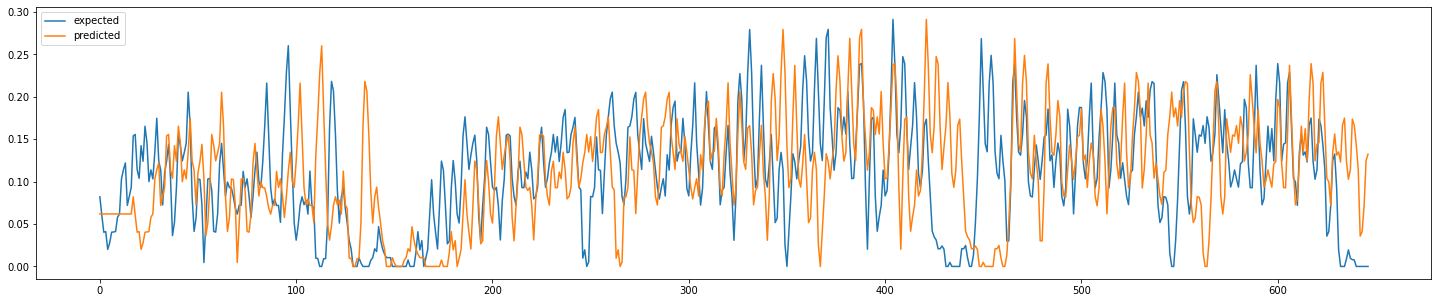

In [ ]:
mb = learner.metabase.metabase.dropna()

y_true = mb[META_LABEL_METRIC]
y_pred = mb[f'last_{META_LABEL_METRIC}']
x = range(len(y_true))

fig = plt.figure(figsize=(25, 5))
plt.plot(x, y_true, label="expected")
plt.plot(x, y_pred, label="predicted")
plt.legend(loc="upper left")

# Save metadata

In [ ]:
mb.to_csv(f"metabases/{FILE_NAME}.csv", index=False)

In [ ]:
with open(f"models/{FILE_NAME}.pickle", "wb") as handle:
    pickle.dump(learner.meta_model.model, handle, protocol=pickle.HIGHEST_PROTOCOL)